<a href="https://colab.research.google.com/github/cbalkig/Anomaly_Detection_in_Videos/blob/master/eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install keras_layer_normalization

  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.14.0-cp36-none-any.whl size=5267 sha256=b09c3ca410d780b69441fc509bf7a53dfcda1cb8db83225406e60df7343a85ea
  Stored in directory: /root/.cache/pip/wheels/54/80/22/a638a7d406fd155e507aa33d703e3fa2612b9eb7bb4f4fe667
Successfully built keras-layer-normalization


got model
got test


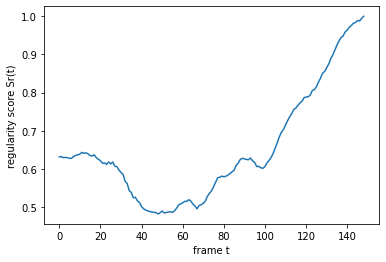

In [3]:
import os
from os import listdir
from os.path import join, isdir
import numpy as np
from PIL import Image
import keras
from keras.layers import Conv2DTranspose, ConvLSTM2D, TimeDistributed, Conv2D
from keras.models import Sequential, load_model
from keras_layer_normalization import LayerNormalization
import matplotlib.pyplot as plt

working_directory = '/content/drive/MyDrive/AnomalyDetectionInVideos'


class Config:
    SINGLE_TEST_PATH = os.path.join(working_directory, "files", "769a3c79-f730-4f05-becf-ee9535131173")
    BATCH_SIZE = 4
    MODEL_PATH = os.path.join(working_directory, "model.hdf5")
    FRAME_SIZE = 10
    THRESHOLD = 159


def get_model():
    return load_model(Config.MODEL_PATH, custom_objects={'LayerNormalization': LayerNormalization})


def get_single_test():
    test = np.zeros(shape=(Config.THRESHOLD, 256, 256, 1))
    cnt = 0
    for f in sorted(listdir(Config.SINGLE_TEST_PATH)):
        directory_path = join(Config.SINGLE_TEST_PATH, f)
        if isdir(directory_path):
            for c in listdir(directory_path):
              if len(c) < 7:
                os.rename(join(directory_path, c), join(directory_path, c.zfill(7)))

    for f in sorted(listdir(Config.SINGLE_TEST_PATH)):
        if str(join(Config.SINGLE_TEST_PATH, f))[-3:] == "tif":
            img = Image.open(join(Config.SINGLE_TEST_PATH, f)).resize((256, 256))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
            if cnt >= Config.THRESHOLD:
                break
    return test


def evaluate(model):
    print("got model")
    test = get_single_test()
    print("got test")
    sz = test.shape[0] - Config.FRAME_SIZE
    sequences = np.zeros((sz, Config.FRAME_SIZE, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((Config.FRAME_SIZE, 256, 256, 1))
        for j in range(0, Config.FRAME_SIZE):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences, batch_size=Config.BATCH_SIZE)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0, sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    # plot the regularity scores
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()


if __name__ == '__main__':
    model = get_model()
    evaluate(model)